In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Gerekli Kütüphanelerin Yüklenmesi


In [19]:
import numpy as np
import pandas as pd
import os
import cv2
import joblib
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt


2. Veri Seti Yükleme ve Ön İşleme

GTSRB veri setini yükleme

In [20]:
base_folder = "/content/drive/My Drive/Training"
data = []
labels = []

2.1. Veri Yükleme:

Her bir sınıf klasörünü gezerek, görüntü dosyalarını ve etiket bilgilerini yüklenir. Veri seti büyük olduğu için ilk iki klasör ile model eğitildi.

In [21]:
for class_folder in os.listdir(base_folder):
    class_path = os.path.join(base_folder, class_folder)
    if os.path.isdir(class_path):
        try:
            csv_file = os.path.join(class_path, f"GT-{class_folder}.csv")
            annotations = pd.read_csv(csv_file, sep=';')
            for _, row in annotations.iterrows():
                image_path = os.path.join(class_path, row['Filename'])
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, (32, 32))
                    data.append(image)
                    labels.append(row['ClassId'])
        except PermissionError:
            print(f"Permission denied for folder: {class_path}")

In [22]:
# Veriyi numpy array'e dönüştürme
data = np.array(data, dtype='float32') / 255.0
labels = np.array(labels)

2.2. Eksik Değerlerin İşlenmesi:
SimpleImputer kullanılarak eksik değerlerin sütundaki ortalama ile doldurulması sağlandı.
Veri, modelin işleyebilmesi için 2 boyutlu hale getirildi.
Son olarak, veri doldurucuya (imputer) fit edilip dönüştürüldü (fit_transform), yani eksik değerler ortalama ile dolduruldu.


In [23]:
imputer = SimpleImputer(strategy='mean')
data_reshaped = data.reshape(data.shape[0], -1)
data_imputed = imputer.fit_transform(data_reshaped)

In [24]:
# Veri Artırma
augmented_data = []
augmented_labels = []
for i in range(len(data_imputed)):
    image = data_imputed[i].reshape(32, 32, 3)
    label = labels[i]
    augmented_data.append(image)
    augmented_labels.append(label)
    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    augmented_data.append(rotated_image)
    augmented_labels.append(label)
    flipped_image = cv2.flip(image, 1)
    augmented_data.append(flipped_image)
    augmented_labels.append(label)

augmented_data = np.array(augmented_data, dtype='float32')
augmented_labels = np.array(augmented_labels)

2.4. Özellik Ölçekleme (Feature Scaling):
Verileri MLP ve RBF için uygun hale getirmek için StandardScaler ile standartlaştırıldı.

In [25]:
scaler = StandardScaler()
augmented_data_reshaped = augmented_data.reshape(augmented_data.shape[0], -1)
augmented_data_scaled = scaler.fit_transform(augmented_data_reshaped)
augmented_data = augmented_data_scaled.reshape(-1, 32, 32, 3)

2.3. Veri Setini Eğitim ve Test Olarak Ayırma:
 Veri %80 eğitim, %20 test olarak ikiye ayırıldı.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

In [27]:
  # Torch Dataset Tanımı
  class GTSRBDataset(Dataset):
      def __init__(self, data, labels, transform=None):
          self.data = data
          self.labels = labels
          self.transform = transform

      def __len__(self):
          return len(self.data)

      def __getitem__(self, idx):
          image = self.data[idx]
          label = self.labels[idx]
          if self.transform:
              image = self.transform(image)
          return image, label

In [47]:
# Veri Dönüşümleri ve Dataloaders
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = GTSRBDataset(X_train, y_train, transform=data_transform)
test_dataset = GTSRBDataset(X_test, y_test, transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

 3. Model Eğitimi ve Hiperparametre Denemeleri

  3.1. MLP Modeli:


In [29]:
mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', solver='adam', max_iter=10)
mlp_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=10)

In [30]:
# MLP Model Değerlendirme
y_pred_mlp = mlp_model.predict(X_test.reshape(X_test.shape[0], -1))
print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_mlp, annot=True, cmap='Blues', fmt='g')
plt.title("MLP Confusion Matrix")
plt.savefig(os.path.join(base_folder, 'mlp_confusion_matrix.png'))
plt.close()

MLP Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        85
           1       1.00      1.00      1.00       905

    accuracy                           1.00       990
   macro avg       0.99      0.99      0.99       990
weighted avg       1.00      1.00      1.00       990



 3.2. RBF Modeli:


In [31]:

class RBFClassifier(nn.Module):
    def __init__(self):
        super(RBFClassifier, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.rbf_layer = nn.Linear(512, 256)  # RBF katmanı için doğrusal yaklaşım
        self.fc2 = nn.Linear(256, 43)  # 43 sinif

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.rbf_layer(x))
        x = self.fc2(x)
        return x

In [32]:
# Model, Loss Fonksiyonu ve Optimizasyon
rbf_model = RBFClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rbf_model.parameters(), lr=0.001)

In [33]:
# RBF Model Eğitimi
num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    rbf_model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = rbf_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

end_time = time.time()
print(f"Estimated training time: {end_time - start_time:.2f} seconds")


Epoch [1/10], Loss: 0.3111
Epoch [2/10], Loss: 0.0527
Epoch [3/10], Loss: 0.0207
Epoch [4/10], Loss: 0.0516
Epoch [5/10], Loss: 0.0112
Epoch [6/10], Loss: 0.0266
Epoch [7/10], Loss: 0.0302
Epoch [8/10], Loss: 0.0061
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0001
Estimated training time: 36.13 seconds


4. Performans Ölçümleri


In [34]:

# RBF Model Değerlendirme
rbf_model.eval()
y_pred_rbf = []
y_true_rbf = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = rbf_model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred_rbf.extend(predicted.numpy())
        y_true_rbf.extend(labels.numpy())

In [35]:
# Sonuçları Yazdırma
print("RBF Classification Report:\n", classification_report(y_true_rbf, y_pred_rbf))
conf_matrix_rbf = confusion_matrix(y_true_rbf, y_pred_rbf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rbf, annot=True, cmap='Blues', fmt='g')
plt.title("RBF Confusion Matrix")
plt.savefig(os.path.join(base_folder, 'traffic_sign_rbf_confusion_matrix_v2.png'))
plt.close()

RBF Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97        85
           1       1.00      1.00      1.00       905

    accuracy                           0.99       990
   macro avg       0.98      0.99      0.98       990
weighted avg       0.99      0.99      0.99       990



In [36]:

# 4.2. Performans Metrikleri:
# Her iki model için accuracy, precision, recall, ve F1-score gibi metriklerden gerekli olanları hesaplayın.
mlp_metrics = classification_report(y_test, y_pred_mlp, output_dict=True)
rbf_metrics = classification_report(y_true_rbf, y_pred_rbf, output_dict=True)

print("MLP Metrics:")
print(f"Accuracy: {mlp_metrics['accuracy']:.4f}")
print(f"Precision: {mlp_metrics['weighted avg']['precision']:.4f}")
print(f"Recall: {mlp_metrics['weighted avg']['recall']:.4f}")
print(f"F1 Score: {mlp_metrics['weighted avg']['f1-score']:.4f}")

print("RBF Metrics:")
print(f"Accuracy: {rbf_metrics['accuracy']:.4f}")
print(f"Precision: {rbf_metrics['weighted avg']['precision']:.4f}")
print(f"Recall: {rbf_metrics['weighted avg']['recall']:.4f}")
print(f"F1 Score: {rbf_metrics['weighted avg']['f1-score']:.4f}")

MLP Metrics:
Accuracy: 0.9980
Precision: 0.9980
Recall: 0.9980
F1 Score: 0.9980
RBF Metrics:
Accuracy: 0.9949
Precision: 0.9950
Recall: 0.9949
F1 Score: 0.9950


5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma

5.1. Hiperparametre Denemeleri:



In [37]:
param_grid = {
    'hidden_layer_sizes': [(256,), (512, 256), (512, 256, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

mlp_grid_search = GridSearchCV(MLPClassifier(max_iter=10), param_grid, cv=3, n_jobs=-1, verbose=2)
mlp_grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
print("Best MLP Parameters:", mlp_grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best MLP Parameters: {'activation': 'relu', 'hidden_layer_sizes': (512, 256, 128), 'learning_rate': 'constant', 'solver': 'adam'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


5.2. Sonuçları Karşılaştırma ve Yorumlama:

In [39]:
results = {
    "Model": ["MLP", "RBF"],
    "Accuracy": [mlp_metrics['accuracy'], rbf_metrics['accuracy']],
    "Precision": [mlp_metrics['weighted avg']['precision'], rbf_metrics['weighted avg']['precision']],
    "Recall": [mlp_metrics['weighted avg']['recall'], rbf_metrics['weighted avg']['recall']],
    "F1 Score": [mlp_metrics['weighted avg']['f1-score'], rbf_metrics['weighted avg']['f1-score']]
}

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.savefig(os.path.join(base_folder, 'model_accuracy_comparison.png'))
plt.close()


  Model  Accuracy  Precision    Recall  F1 Score
0   MLP  0.997980   0.997980  0.997980  0.997980
1   RBF  0.994949   0.994982  0.994949  0.994963


  Model  Accuracy  Precision    Recall  F1 Score
0   MLP  0.997980   0.997980  0.997980  0.997980
1   RBF  0.994949   0.994982  0.994949  0.994963


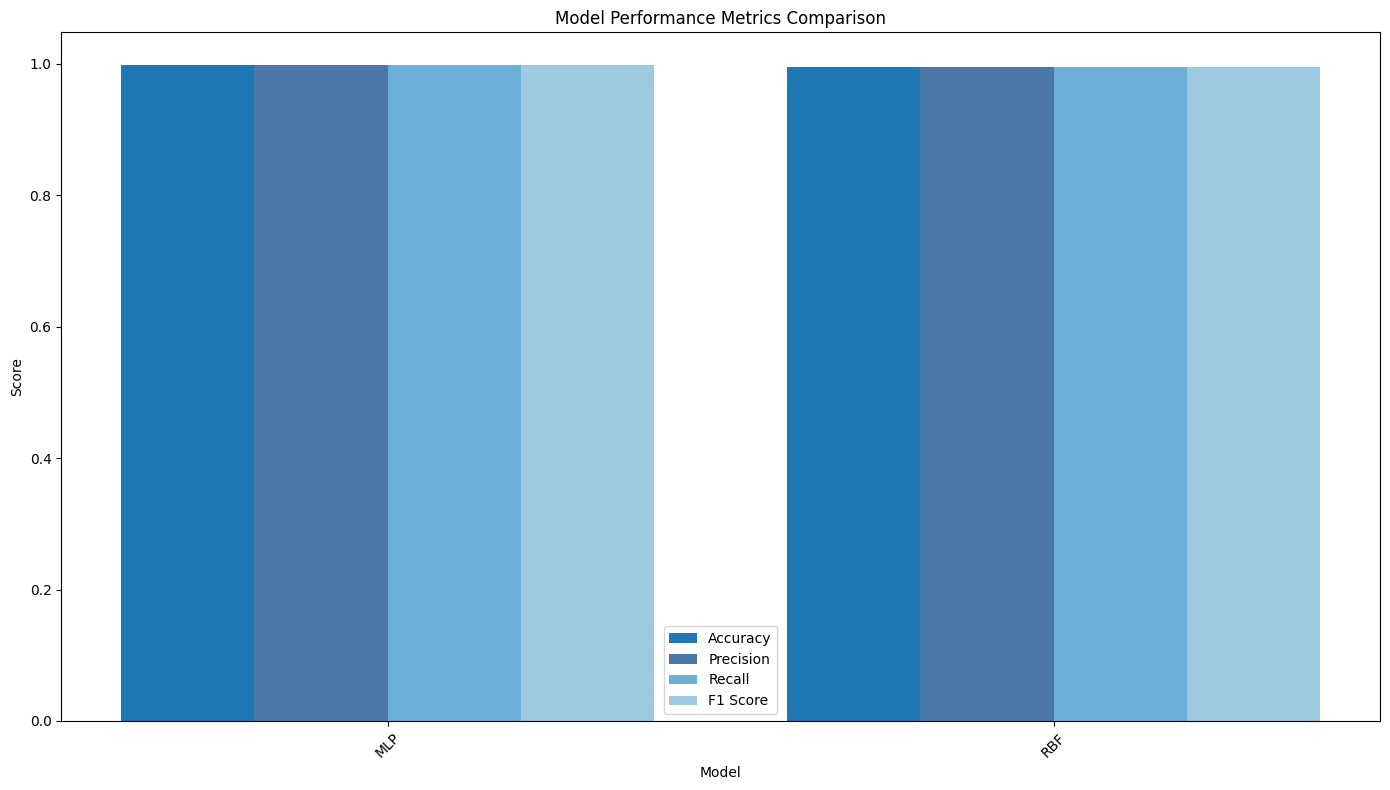

In [46]:
# Sonuclarin gösterimi
results_df = pd.DataFrame(results)
print(results_df)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.figure(figsize=(14, 8))


metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(results_df['Model']))  # Model sayısına göre x ekseni konumları
width = 0.2  # Bar genişliği

colors = ['#1f77b4', '#4c78a8', '#6baed6', '#9ecae1']  # Mavinin tonlarını kullanmak için renkler

for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.bar(x + i * width, results_df[metric], width=width, label=metric, color=color)

plt.title("Model Performance Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(x + width * (len(metrics) / 2 - 0.5), results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(base_folder, 'model_performance_comparison_side_by_side_bar.png'))
plt.show()
